In [132]:
import numpy as np
from collections import defaultdict
from datetime import datetime
import scipy.stats as st
from itertools import product
from tqdm import tqdm
import random
import gym
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym import spaces

import matplotlib.pyplot as plt
%matplotlib inline

## Часть первая, с блекджеком и стратегиями

1) Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.  
2) Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.  
3) Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [133]:
env = gym.make('Blackjack-v0', natural=True)

In [140]:
def simple_policy(env, *args, **kwargs):
    return int(env._get_obs()[0] < 19)

In [141]:
def generate_episode(env, policy, *args, **kwargs):
    states, actions, rewards = [], [], []
    state = env.reset()
    while True:
        action = policy(env, *args, **kwargs)
        next_state, reward, done, _ = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        state = next_state
        if done:
            break
    return states, actions, rewards

In [142]:
def first_visit_mc_prediction(env, policy, n_episodes, *args, **kwargs):
    values = defaultdict(float)
    episode_rewards = []
    N = defaultdict(int)
    
    for _ in range(n_episodes):
        states, actions, rewards = generate_episode(env, policy, *args, **kwargs)
        episode_rewards.append(rewards[-1])
        
        returns = 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R
            if S not in states[:t]:
                N[S] += 1
                values[S] += (returns - values[S]) / N[S]
    return values, episode_rewards

In [143]:
values, rewards = first_visit_mc_prediction(env, simple_policy, n_episodes=500000, gamma=0.2, epsilon_start=1.0, epsilon_decay=0.99999, epsilon_min=0.01)

In [144]:
f"Средний выигрыш простейшей стратегии: {np.mean(rewards)}"

'Средний выигрыш простейшей стратегии: -0.17989'

#### Реализуем Monte Carlo control

In [145]:
def eps_greedy_policy(env, epsilon, Q):
    state = env._get_obs()
    if random.random() > epsilon:
        return Q[state].argmax()
    else:
        return random.randint(0, env.action_space.n - 1)

In [146]:
def mc_control(env, policy, n_episodes, gamma, epsilon_start, epsilon_decay, epsilon_min):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(int)
    mean_rewards = []
    epsilon = epsilon_start
    
    for i in tqdm(range(n_episodes)):
        states, actions, rewards = generate_episode(env, eps_greedy_policy, epsilon=epsilon, Q=Q)

        sa = list(zip(states, actions))
        G = 0
        for t in range(len(states) - 1, -1, -1):
            G = gamma * G + rewards[t]
            if (states[t], actions[t]) not in sa[:t]:
                N[(states[t], actions[t])] += 1
                Q[states[t]][actions[t]] += (G - Q[states[t]][actions[t]]) / N[(states[t], actions[t])]
                
        # Estimate current policy performance
        if i % 30000 == 0:
            episode_rewards = []
            for _ in range(100000):
                states, actions, rewards = generate_episode(env, eps_greedy_policy, epsilon=epsilon, Q=Q)
                episode_rewards.append(rewards[-1])
            mean_rewards.append(np.mean(episode_rewards))
        
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
    
    best_policy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
    return best_policy, Q, mean_rewards

In [173]:
best_policy, best_Q, episode_rewards = mc_control(env, eps_greedy_policy, n_episodes=500000, gamma=1.0, epsilon_start=1.0, epsilon_decay=0.99999, epsilon_min=0.01)

100%|███████████████████████████████████████████████████████████████████████████████████| 500000/500000 [01:20<00:00, 6172.97it/s]


In [174]:
f"Средний выигрыш MC control: {episode_rewards[-1]}"

'Средний выигрыш MC control: -0.048065'

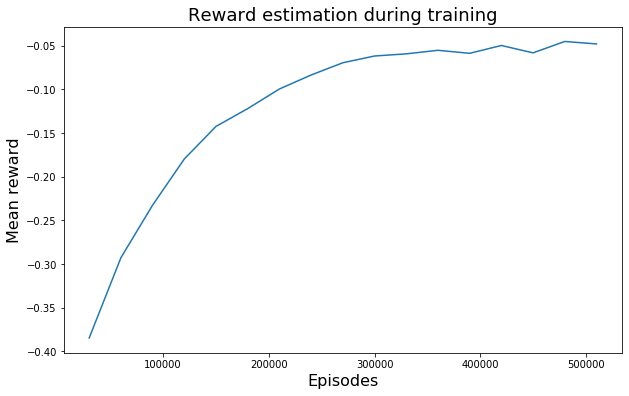

In [175]:
plt.figure(figsize = (10, 6))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(np.arange(1, len(episode_rewards)+1) * 30000, episode_rewards)
plt.show()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие: double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4) Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.  
5) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.  

In [150]:
class DoubleBlackjackEnv(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        super(DoubleBlackjackEnv, self).__init__(*args, **kwargs)
        
        self.action_space = spaces.Discrete(3)
        self.reset()
        
    def step(self, action):
        if action == 2:
            state, reward, done, _ = super(DoubleBlackjackEnv, self).step(1)
            if not done:
                state, reward, done, _ = super(DoubleBlackjackEnv, self).step(0)
            reward = reward * 2
        else:
            state, reward, done, _ = super(DoubleBlackjackEnv, self).step(action)

        return state, reward, done, _

In [151]:
env_double = DoubleBlackjackEnv()

In [179]:
best_policy, best_Q, episode_rewards = mc_control(env_double, eps_greedy_policy, n_episodes=1000000, gamma=0.4, epsilon_start=1.0, epsilon_decay=0.99999, epsilon_min=0.01)

100%|█████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:47<00:00, 5972.66it/s]


In [180]:
f"Средний выигрыш MC control с double: {episode_rewards[-1]}"

'Средний выигрыш MC control с double: -0.04736'

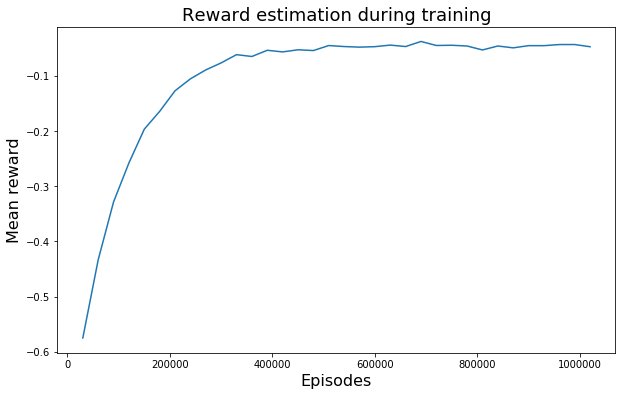

In [181]:
plt.figure(figsize = (10, 6))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(np.arange(1, len(episode_rewards)+1) * 30000, episode_rewards)
plt.show()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6) Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).  
7) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.  

In [155]:
def cmp(a, b):
    return float(a > b) - float(a < b)


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

In [156]:
class CountingBlackjackEnv(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        self.card_values = {
            1: -1,
            2: 1,
            3: 1,
            4: 1,
            5: 1,
            6: 1,
            7: 0,
            8: 0,
            9: 0,
            10: -1,
        }
        
        self.dealer = []
        self.player = []
        self.shuffle_deck()
        
        super(CountingBlackjackEnv, self).__init__(*args, **kwargs)
        
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(21))),

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.deck_counter())
    
    def deck_counter(self):
        status = self.counter
        if status < -10:
            status = -10
        elif status > 10:
            status = 10
        return status + 10

    def shuffle_deck(self):
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        random.shuffle(self.deck)
        self.counter = 0
    
    def reset(self):
        self.dealer = []
        self.dealer.append(self.get_card())
        self.dealer.append(self.get_card(visible=False))
        
        self.player = []
        self.player.append(self.get_card())
        self.player.append(self.get_card())
        return self._get_obs()
    
    def get_card(self, visible=True):
        card = self.deck.pop()
        self.counter += self.card_values[card]
        return card
    
    def step(self, action):
        if action == 2:
            done = True
            self.player.append(self.get_card())
            if is_bust(self.player):
                reward = -1.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.get_card())
                reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 2.:
                reward = 1.5
            
            reward *= 2
            
        elif action == 1:
            self.player.append(self.get_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.get_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        
        if len(self.deck) < 15:
            self.shuffle_deck()

        return self._get_obs(), reward, done, {}

In [157]:
env_counting = CountingBlackjackEnv()

In [182]:
best_policy, best_Q, episode_rewards = mc_control(env_counting, eps_greedy_policy, n_episodes=10000000, gamma=0.2, epsilon_start=1.0, epsilon_decay=0.999999, epsilon_min=0.01)

100%|██████████████████████████████████████████████████████████████████████████████| 10000000/10000000 [10:46<00:00, 15473.16it/s]


In [183]:
f"Средний выигрыш MC control с double и подсчётом карт: {episode_rewards[-1]}"

'Средний выигрыш MC control с double и подсчётом карт: -0.01994'

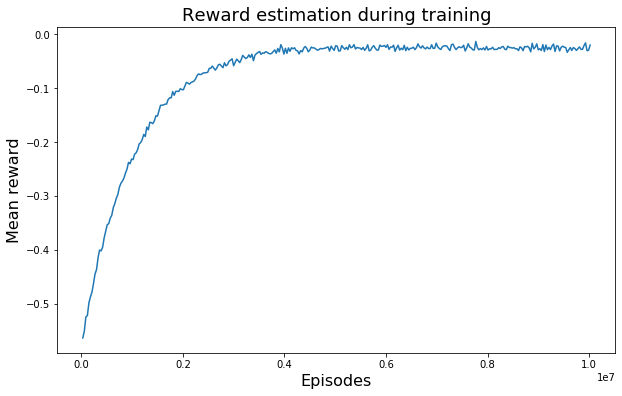

In [184]:
plt.figure(figsize = (10, 6))
plt.title('Reward estimation during training', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Mean reward', fontsize=16)
plt.plot(np.arange(1, len(episode_rewards)+1) * 30000, episode_rewards)
plt.show()